In [115]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from pathlib import Path
from helpers.utils import LaughterDataset
from sklearn.model_selection import train_test_split

In [116]:
# Load labels and add numerical mapping to laugh class
labels = pd.read_csv('data/labels-2.csv')
mappings = {'belly': 0, 'chuckle': 1, 'baby': 2} 
labels['laugh_numerical'] = labels['laugh_class'].map(mappings)
labels

,id,laugh_class,laugh_numerical
0,1,chuckle,1
1,2,chuckle,1
2,3,chuckle,1
3,4,chuckle,1
4,5,chuckle,1
...,...,...,...
129,130,baby,2
130,131,baby,2
131,132,baby,2
132,133,baby,2


In [117]:
ROOT_PATH = Path('data/training-dataset-2')

# Split between training (90%) and testing (10%) labels 
training_labels, testing_labels = train_test_split(labels, train_size=0.8, test_size=0.2)

# This will return datasets splited between training and labels
training_dataset = LaughterDataset(ROOT_PATH, labels=training_labels)
testing_dataset = LaughterDataset(ROOT_PATH, labels=testing_labels)

# Creating Dataloaders for Neural Network
train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=8, shuffle=False)

In [118]:
class LaughCNN(nn.Module):
	def __init__(self):
		super(LaughCNN, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2),
			nn.Conv2d(16, 32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
		)
		self.fc = nn.Sequential(
			nn.Flatten(),
			nn.Linear(32 * 3 * 32, 64),
			nn.ReLU(),
			nn.Linear(64, 3)
		)

	def forward(self, x):
		x = self.conv(x)
		return self.fc(x)

In [119]:
model = LaughCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
	model.train()
	running_loss = 0.0
	for audio, _, _, numerical in train_loader:
			outputs = model(audio)
			loss = criterion(outputs, numerical)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

	print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}")

Epoch 1: Loss = 4.3346
Epoch 2: Loss = 1.1936
Epoch 3: Loss = 0.3747
Epoch 4: Loss = 0.1052
Epoch 5: Loss = 0.0380
Epoch 6: Loss = 0.0151
Epoch 7: Loss = 0.0097
Epoch 8: Loss = 0.0036
Epoch 9: Loss = 0.0022
Epoch 10: Loss = 0.0016
Epoch 11: Loss = 0.0014
Epoch 12: Loss = 0.0010
Epoch 13: Loss = 0.0008
Epoch 14: Loss = 0.0007
Epoch 15: Loss = 0.0006
Epoch 16: Loss = 0.0005
Epoch 17: Loss = 0.0004
Epoch 18: Loss = 0.0004
Epoch 19: Loss = 0.0004
Epoch 20: Loss = 0.0003


In [120]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
		for audio, audio_id, _, numerical in test_loader:
				outputs = model(audio)
				_, predicted = torch.max(outputs, 1)
				predictions.extend(p.item() for p in predicted)
				true_labels.extend(n.item() for n in numerical)
				
print(f'{'Predicted':>{10}}: {predictions}')
print(f'{'True':>{10}}: {true_labels:}')

# print("Classification Report:")
# print(classification_report(labels, preds, target_names=["chuckle", "baby"]))
# print("Confusion Matrix:")
# print(confusion_matrix(labels, preds))

 Predicted: [2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2]
      True: [2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2]


In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuraccy = accuracy_score(predictions, true_labels)
precision = precision_score(predictions, true_labels)
recall = recall_score(predictions, true_labels)
F1_score = f1_score(predictions, true_labels)
print(accuraccy)
print(precision)
print(recall)
print(F1_score)

cm = confusion_matrix(y_true=true_labels, y_pred=predictions)

from sklearn.metrics import classification_report, confusion_matrix
# print("Classification Report:")
# print(classification_report(true_labels, predictions, target_names=["chuckle", "baby"]))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))

0.8518518518518519
0.9
0.75
0.8181818181818182
Confusion Matrix:
[[ 9  1]
 [ 3 14]]


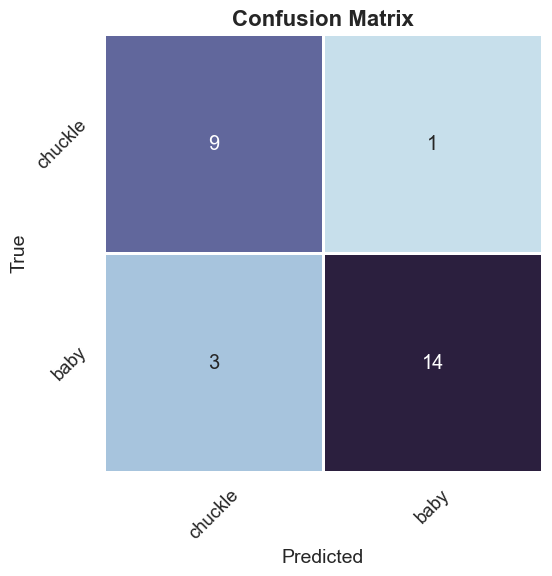

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

tags = ["chuckle", "baby"]

plt.figure(figsize=(7, 6))
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
# cmpa sns.color_palette("light:#5A9", as_cmap=True)

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap=cmap,  # Better gradient
    xticklabels=tags,
    yticklabels=tags,
    linewidths=1,
    linecolor='white',
    cbar=False,  # Optional: remove if you don't need the color bar
    square=True
)

ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("True", fontsize=14)
ax.set_title("Confusion Matrix", fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
